In [1]:
%config Completer.use_jedi = False


In [2]:
from prosittransformer.ceCalibrationPlot import CeCalibation

In [ ]:
%config Completer.use_jedi = False


from torch.utils.data import Dataset
from tape.tokenizers import TAPETokenizer
from typing import List, Tuple, Any, Dict
import torch
from torch.utils.data import DataLoader, RandomSampler, Dataset
from tape.utils._sampler import BucketBatchSampler
from tape.datasets import pad_sequences
from tape import ProteinBertForValuePredictionFragmentationProsit
from prosittransformer.utils import cleanTapeOutput
from tqdm import tqdm
import pickle
import multiprocessing
import numpy as np

torch.multiprocessing.set_sharing_strategy('file_system')
import pickle
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from tape.datasets import PrositFragmentationDataset
import pandas as pd

In [ ]:
class SelectCEData:
    def __init__(self, lmdb : str, selected_ce : List[float] = [0.2, 0.25, 0.3, 0.35, 0.4]):
        self.PrositData = PrositFragmentationDataset(lmdb, "test")
        self._ceDataDict = {ce : [] for ce in selected_ce }
    @property
    def ceDataDict(self):
        return self._ceDataDict
    
    def getCEdata(self)->dict:
        #Loop each element in dataset
        for i in tqdm(range(len(self.PrositData))):
            for k in self._ceDataDict.keys():
                ce = np.round(self.PrositData[i][3], 2)
                if ce == np.array(k, dtype=np.float32):
                    self._ceDataDict[k].append(self.PrositData[i])
        return self._ceDataDict


In [ ]:
#SelectCE = SelectCEData("/sdd/PrositToTapeDataConverter/LMDB")

In [ ]:
#ceDataDict = SelectCE.getCEdata()

In [ ]:
#ceDataDict = pickle.load(open("./data/ceDataDict.pkl", "rb"))
#pickle.dump(ceDataDict, open("./data/ceDataDict.pkl", "wb"))

In [ ]:
class PrositFragmentationCEDataset(Dataset):

    def __init__(self,
                 data: dict,
                 ce: float):

        tokenizer = TAPETokenizer(vocab="iupac")
        self.tokenizer = tokenizer
        self.data = data
        self.ce = ce
        self.keys = [
                     'intensities_raw',
                     'collision_energy_aligned_normed',
                     'precursor_charge_onehot'
                     ]
                     
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        return self.data[index][:3] + tuple([np.array(self.ce, dtype=np.float32)]) + self.data[index][4:]

    def collate_fn(self, batch: List[Tuple[Any, ...]]) -> Dict[str, torch.Tensor]:
        input_ids, input_mask, intensities_raw_true_value, collision_energy, charge = tuple(zip(*batch))

        collision_energy = np.stack(collision_energy)
        input_ids = torch.from_numpy(pad_sequences(input_ids, 0))
        input_mask = torch.from_numpy(pad_sequences(input_mask, 0))
        intensities_raw_true_value = torch.FloatTensor(intensities_raw_true_value)  # type: ignore

        collision_energy_tensor = torch.FloatTensor(collision_energy)
        charge_tensor = torch.FloatTensor(charge)

        return {'input_ids': input_ids,
                'input_mask': input_mask,
                'targets': intensities_raw_true_value,
                'collision_energy': collision_energy_tensor,
                'charge': charge_tensor}

In [ ]:
class CreateDataLoader:
    @staticmethod
    def getDataLoader(dataset: PrositFragmentationDataset)->DataLoader:
        sampler = RandomSampler(dataset)
        batch_sampler = BucketBatchSampler(sampler, 64, False, lambda x: len(x[0]), dataset)
        loader = DataLoader(
                dataset,
                num_workers=multiprocessing.cpu_count() - 2,
                collate_fn=dataset.collate_fn,  # type: ignore
                batch_sampler=batch_sampler)
        return loader
    
class PytorchModel:
    @staticmethod
    def getModel(path : str)->ProteinBertForValuePredictionFragmentationProsit:
        pytorch_model = ProteinBertForValuePredictionFragmentationProsit.from_pretrained(path)
        pytorch_model = pytorch_model.to(torch.device('cuda:0'))
        return pytorch_model

In [ ]:
class CeCalibation(SelectCEData, cleanTapeOutput, CreateDataLoader, PytorchModel):
    def __init__(self, lmdb: str, pytorch_model: str, out_dir: str, ce_range : np.array = np.linspace(0.10,0.5,41)):
        cleanTapeOutput.__init__(self)
        CreateDataLoader.__init__(self)
        PytorchModel.__init__(self)
        SelectCEData.__init__(self, lmdb)
        PytorchModel.__init__(self)
        self.model = self.getModel(pytorch_model)
        self.out_dir = out_dir
        self.ce_range = ce_range
        
    def _getSa(self, loader)->float:
        sa_list = list()
        for i, batch in tqdm(enumerate(loader), total=len(loader)):  
            batch = {name: tensor.cuda(device=torch.device('cuda:0'), non_blocking=True)
                         for name, tensor in batch.items()}

            targets = batch["targets"].cpu().detach().numpy()
            charge = batch["charge"].cpu().detach().numpy()
            sequence = batch["input_ids"].cpu().detach().numpy()
            predictions = self.model(**batch)[1].cpu().detach().numpy()
            sa, _ = self.getIntensitiesAndSpectralAngle(predictions, targets, charge, sequence, True)
            sa_list.append(sa)

            if i == 3:
                break
        return np.median(np.concatenate(sa_list))
    
    def _getCeCalibSeries(self, data, range_x):
        sa_list = list()
        for i in range_x:
            dataset = PrositFragmentationCEDataset(data, round(i,2))
            loader = self.getDataLoader(dataset)
            sa_list.append(self._getSa(loader))
        return sa_list
    
    def _makeFig(self, df):
        fs=16 + 5
        plt.figure(figsize=(16, 10))
        ax = seaborn.lineplot(x="ce", y="sa", marker="o", hue="CE", data = df, palette=["C0", "C1", "C2","C3", "C4"])
        legend = ax.legend(handles=ax.legend_.legendHandles,
                           prop={"size":fs})


        #plt.legend.get_title().set_fontsize('6')
        #plt.rcParams['legend.title_fontsize'] = fs
        plt.xlabel("Collision Energy", fontsize=fs)
        plt.ylabel("Median Spectral Angle", fontsize=fs)
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)
        plt.plot([0.2, 0.2], [0, 1], color="C0")
        plt.plot([0.25, 0.25], [0, 1], color="C1")
        plt.plot([0.3, 0.3], [0, 1], color="C2")
        plt.plot([0.35, 0.35], [0, 1], color="C3")
        plt.plot([0.4, 0.4], [0, 1], color="C4")
        plt.tight_layout()

        plt.savefig(f"{self.out_dir}CeCalibation.png")
    
    
    def _getCeCalibationDF(self):
        
        #ceDataDict = self.getCEdata()
        #pickle.dump(ceDataDict, open("./data/ceDataDict.pkl", "wb"))
        ceDataDict = pickle.load(open("./data/ceDataDict.pkl", "rb"))
        data_points = list()
        for ce in list(ceDataDict.keys()):
            CE_DATA = ceDataDict[ce]
            if len(CE_DATA) == 0:
                print(f"no data for {ce}. Skip to next ce.")
                continue
                
            sa_list = self._getCeCalibSeries(CE_DATA, self.ce_range)
    
            for s, r in zip(sa_list, self.ce_range):
                data_points.append([s,r, ce])
            
        df = pd.DataFrame(data_points, columns=["sa", "ce", "CE"])
        return df
    
    def CeCalibarationReport(self):
        df = self._getCeCalibationDF()
        df.to_csv(f"{self.out_dir}CeCalibation.csv")
        self._makeFig(df)

        
    

In [6]:
s ="d"

In [8]:
s.endswith("/")

False

In [5]:
!ls  /home/ekvall/prosittransformer/notebooks/data

CeCalibation.csv  CeCalibation.png  ceDataDict.pkl


In [3]:
Calib = CeCalibation("/sdd/PrositToTapeDataConverter/LMDB", "/sdd/berzelius/torch_model", "/home/ekvall/prosittransformer/notebooks/data/")

  2%|▏         | 3/127 [00:00<00:10, 11.73it/s]


  2%|▏         | 3/127 [00:00<00:08, 14.81it/s]


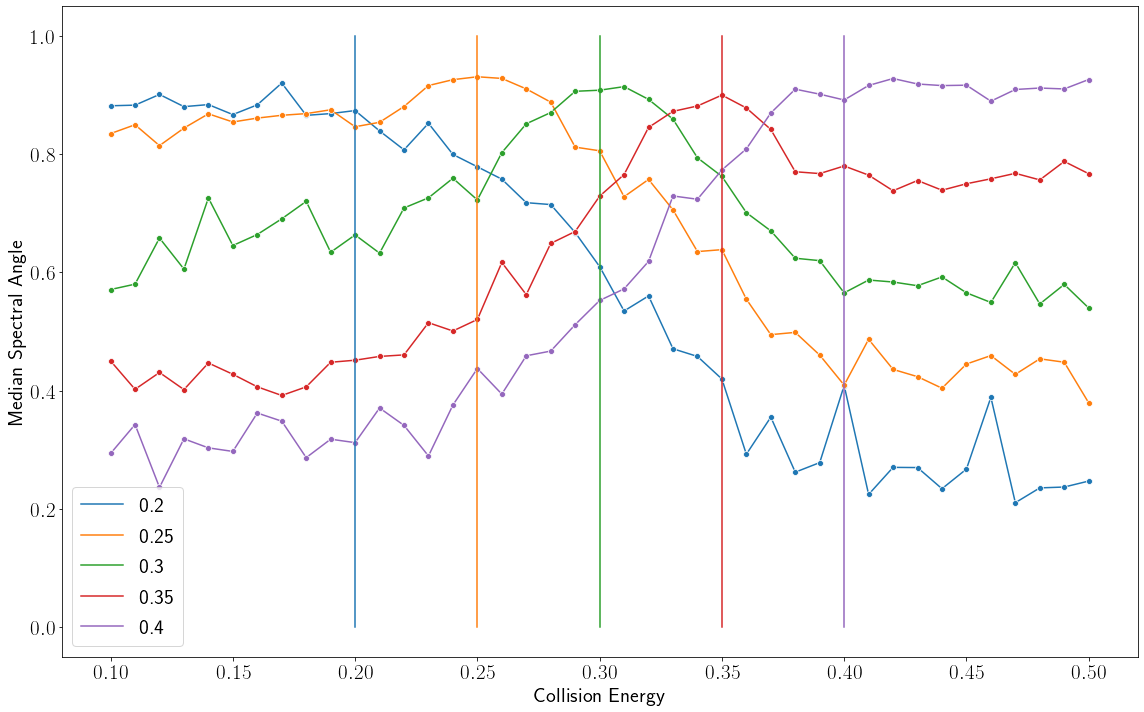

In [4]:
Calib.CeCalibarationReport()

In [ ]:
fs=16 + 5
plt.figure(figsize=(16, 10))
ax = seaborn.lineplot(x="ce", y="sa", marker="o", hue="CE", data = df, palette=["C0", "C1", "C2","C3", "C4"])
legend = ax.legend(handles=ax.legend_.legendHandles,
                   prop={"size":fs})


#plt.legend.get_title().set_fontsize('6')
#plt.rcParams['legend.title_fontsize'] = fs
plt.xlabel("Collision Energy", fontsize=fs)
plt.ylabel("Median Spectral Angle", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.plot([0.2, 0.2], [0, 1], color="C0")
plt.plot([0.25, 0.25], [0, 1], color="C1")
plt.plot([0.3, 0.3], [0, 1], color="C2")
plt.plot([0.35, 0.35], [0, 1], color="C3")
plt.plot([0.4, 0.4], [0, 1], color="C4")

#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=6)

#plt.savefig("./compare.png")

In [ ]:
CTO = cleanTapeOutput()

In [ ]:
targets = np.concatenate(targets)
charge = np.concatenate(charge)
sequence = np.concatenate(sequence)
predictions = np.concatenate(predictions)

In [ ]:
sa, _ = CTO.getIntensitiesAndSpectralAngle(predictions, targets, charge, sequence, True)

In [ ]:
%config Completer.use_jedi = False

import numpy as np
from tqdm import tqdm

In [ ]:
from tape.datasets import PrositFragmentationDataset
PrositData = PrositFragmentationDataset("/sdd/PrositToTapeDataConverter/LMDB", "test")
x = {
    0.25 : [],
    0.3 : [],
    0.35 : [],
    0.4 : [],
    0.45 : [],
    0.5 : []
}
def getCEdata(ceDataDict:dict, Dataset: PrositFragmentationDataset)->dict:
    #Loop each element in dataset
    for i in tqdm(range(len(Dataset))):
        for k in ceDataDict.keys():
            if np.round(Dataset[i][3], 2) == np.array(k, dtype=np.float32):
                ceDataDict[k].append(Dataset[i])
    return ceDataDict


In [ ]:
def getCEdata(ceDataDict:dict, Dataset: PrositFragmentationDataset)->dict:
    #Loop each element in dataset
    for i in tqdm(range(len(Dataset))):
        for k in ceDataDict.keys():
            if np.round(Dataset[i][3], 2) == np.array(k, dtype=np.float32):
                ceDataDict[k].append(Dataset[i])
    return ceDataDict


In [ ]:
from torch.utils.data import Dataset
from tape.tokenizers import TAPETokenizer
from typing import List, Tuple, Any, Dict
import torch

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, Dataset
from tape.utils._sampler import BucketBatchSampler

In [ ]:
class PrositFragmentationDataset(Dataset):

    def __init__(self,
                 data: dict,
                 ce: float):

        tokenizer = TAPETokenizer(vocab="iupac")
        self.tokenizer = tokenizer
        self.data = data
        self.ce = ce
        self.keys = [
                     'intensities_raw',
                     'collision_energy_aligned_normed',
                     'precursor_charge_onehot'
                     ]
                     
    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        return self.data[index][:3] + tuple([np.array(self.ce, dtype=np.float32)]) + self.data[index][4:]

    def collate_fn(self, batch: List[Tuple[Any, ...]]) -> Dict[str, torch.Tensor]:
        input_ids, input_mask, intensities_raw_true_value, collision_energy, charge = tuple(zip(*batch))

        collision_energy = np.stack(collision_energy)
        input_ids = torch.from_numpy(pad_sequences(input_ids, 0))
        input_mask = torch.from_numpy(pad_sequences(input_mask, 0))
        intensities_raw_true_value = torch.FloatTensor(intensities_raw_true_value)  # type: ignore

        collision_energy_tensor = torch.FloatTensor(collision_energy)
        charge_tensor = torch.FloatTensor(charge)

        return {'input_ids': input_ids,
                'input_mask': input_mask,
                'targets': intensities_raw_true_value,
                'collision_energy': collision_energy_tensor,
                'charge': charge_tensor}

In [ ]:
from tape.datasets import pad_sequences

In [ ]:
import pickle
import multiprocessing
#ceDataDict = getCEdata(x, PrositData)
#pickle.dump(ceDataDict, open("./data/ceDataDict.pkl", "wb"))

In [ ]:
ce25Dataset = PrositFragmentationDataset(ceDataDict[0.25], 0.3)

In [ ]:
ce25Dataset[0]

In [ ]:
sampler = RandomSampler(ce25Dataset)
batch_sampler = BucketBatchSampler(sampler, 64, False, lambda x: len(x[0]), ce25Dataset)
loader = DataLoader(
        ce25Dataset,
        num_workers=multiprocessing.cpu_count() - 1,
        collate_fn=ce25Dataset.collate_fn,  # type: ignore
        batch_sampler=batch_sampler)

In [ ]:
from tape import ProteinBertForValuePredictionFragmentationProsit

In [ ]:
pytorch_model = ProteinBertForValuePredictionFragmentationProsit.from_pretrained("/sdd/berzelius/torch_model")
if torch.cuda.is_available():
    use_gpu = True
    pytorch_model = pytorch_model.to(torch.device('cuda:0'))
else:
    use_gpu = False

In [ ]:
CTO = cleanTapeOutput()

In [ ]:
predictions = list()
targets = list()
for batch in tqdm(loader):  
    targets.append(batch["targets"].cpu().detach().numpy())
    if use_gpu:
        batch = {name: tensor.cuda(device=torch.device('cuda:0'), non_blocking=True)
                 for name, tensor in batch.items()}
    predictions.append(pytorch_model(**batch)[1].cpu().detach().numpy())
    break

In [ ]:
targets

In [ ]:
predictions

In [ ]:
CTO = cleanTapeOutput()

In [ ]:
CTO.

In [ ]:
pytorch_model = ProteinBertForValuePredictionFragmentationProsit.from_pretrained(model)
    if torch.cuda.is_available():
        use_gpu = True
        pytorch_model = pytorch_model.to(torch.device('cuda:0'))
    else:
        use_gpu = False
   
    loader = getTorchDataLoader(lmdb, split, batch_size = batch_size)
    predictions = list()
    for batch in tqdm(loader):  
        if use_gpu:
            batch = {name: tensor.cuda(device=torch.device('cuda:0'), non_blocking=True)
                     for name, tensor in batch.items()}
        predictions.append(pytorch_model(**batch)[1].cpu().detach().numpy())
    predictions = np.concatenate(predictions)

In [ ]:
for b in loader:
    break

In [ ]:
b

In [ ]:

    batch_sampler = BucketBatchSampler(
        sampler, batch_size, False, lambda x: len(x[0]), dataset)

    loader = DataLoader(
        dataset,
        num_workers=num_workers,
        collate_fn=dataset.collate_fn,  # type: ignore
        batch_sampler=batch_sampler)

In [ ]:
ceDataDict[0.25][0][:3] + tuple([np.array(0.3, dtype=np.float32)]) + ceDataDict[0.25][0][4:]

In [ ]:
ceDataDict[0.25][0][4:]

In [ ]:
([np.array(0.3, dtype=np.float32)])

In [ ]:
x == np.array(0.32, dtype=np.float32)

In [ ]:
np.round(TEST[0][3], 2)